# Basic Skeleton

# Imports

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
import urllib

from torchsummary import summary
from tqdm import tqdm

# Data Transforms

In [3]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset and Creating Train/Test Split

In [4]:
train_dataset = datasets.MNIST('./data',
                              train=True,
                              transform=train_transforms,
                              download=True)

test_dataset = datasets.MNIST('./data',
                              train=False,
                              transform=test_transforms,
                              download=True)

# Dataloader

In [5]:
SEED = 1
torch.manual_seed(SEED)

cuda = torch.cuda.is_available()
if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

In [6]:
cuda

True

# Data Statistics

Numpy shape  (60000, 28, 28)
Tensor size  torch.Size([60000, 28, 28])
min  tensor(-0.4242)
max  tensor(2.8215)
mean  tensor(0.0006)
std  tensor(1.0000)
var  tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


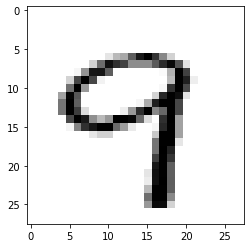

In [7]:
train_data = train_dataset.data
train_data = train_dataset.transform(train_data.numpy())

print('Numpy shape ', train_dataset.data.cpu().numpy().shape)
print('Tensor size ', train_dataset.data.size())
print('min ', torch.min(train_data))
print('max ', torch.max(train_data))
print('mean ', torch.mean(train_data))
print('std ', torch.std(train_data))
print('var ', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
plt.show()

# Model

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Parameters

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,432
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 22, 22]          73,728
              ReLU-6          [-1, 128, 22, 22]               0
         MaxPool2d-7          [-1, 128, 11, 11]               0
            Conv2d-8           [-1, 32, 11, 11]           4,096
              ReLU-9           [-1, 32, 11, 11]               0
           Conv2d-10             [-1, 64, 9, 9]          18,432
             ReLU-11             [-1, 64, 9, 9]               0
           Conv2d-12            [-1, 128, 7, 7]          73,728
             ReLU-13            [-1, 128, 7, 7]               0
           Conv2d-14             [-1, 1

# Training and Testing

In [24]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)
        
        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
        
        # Predict
        y_pred = model(data)
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Update pbar-tqdm
        
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))  

In [25]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.14135824143886566 Batch_id=468 Accuracy=68.06: 100%|██████████| 469/469 [00:06<00:00, 74.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1936, Accuracy: 9400/10000 (94.00%)

EPOCH: 1


Loss=0.07125630229711533 Batch_id=468 Accuracy=96.23: 100%|██████████| 469/469 [00:06<00:00, 75.11it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0698, Accuracy: 9780/10000 (97.80%)

EPOCH: 2


Loss=0.12886075675487518 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:06<00:00, 74.91it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0557, Accuracy: 9822/10000 (98.22%)

EPOCH: 3


Loss=0.09912275522947311 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:06<00:00, 74.82it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9846/10000 (98.46%)

EPOCH: 4


Loss=0.07095596194267273 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:06<00:00, 74.62it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9854/10000 (98.54%)

EPOCH: 5


Loss=0.04547702148556709 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:06<00:00, 74.44it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9870/10000 (98.70%)

EPOCH: 6


Loss=0.06371954083442688 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:06<00:00, 74.45it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9885/10000 (98.85%)

EPOCH: 7


Loss=0.06047108396887779 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:06<00:00, 74.16it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9892/10000 (98.92%)

EPOCH: 8


Loss=0.012330636382102966 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:06<00:00, 74.03it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9881/10000 (98.81%)

EPOCH: 9


Loss=0.04786121845245361 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:06<00:00, 73.78it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9890/10000 (98.90%)

EPOCH: 10


Loss=0.05847851559519768 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:06<00:00, 73.78it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9885/10000 (98.85%)

EPOCH: 11


Loss=0.11123993992805481 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:06<00:00, 74.03it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9894/10000 (98.94%)

EPOCH: 12


Loss=0.008692950010299683 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:06<00:00, 73.28it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9885/10000 (98.85%)

EPOCH: 13


Loss=0.004880070686340332 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:06<00:00, 72.96it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9874/10000 (98.74%)

EPOCH: 14


Loss=0.016368359327316284 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:06<00:00, 73.30it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9912/10000 (99.12%)

EPOCH: 15


Loss=0.0005850990419276059 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:06<00:00, 73.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9882/10000 (98.82%)

EPOCH: 16


Loss=0.0021883349400013685 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:06<00:00, 73.22it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9891/10000 (98.91%)

EPOCH: 17


Loss=0.007231732364743948 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:06<00:00, 72.17it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9893/10000 (98.93%)

EPOCH: 18


Loss=0.003156771184876561 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:06<00:00, 72.71it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9904/10000 (99.04%)

EPOCH: 19


Loss=0.00016314785170834512 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:06<00:00, 71.94it/s]



Test set: Average loss: 0.0405, Accuracy: 9891/10000 (98.91%)



Text(0.5, 1.0, 'Test Accuracy')

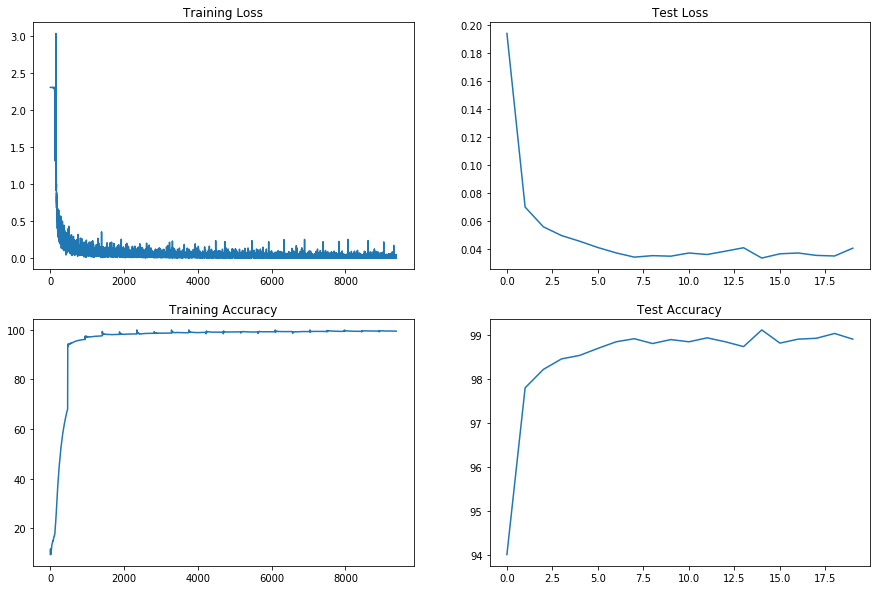

In [26]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Result Analysis

- Model Parameters - 194k 
- Best train acc -  99.52 
- Best test acc -  99.12